In [1]:
import json
import math
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/home/x_x/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I. Load the data & some insights

In [2]:
# We load the 3 datasets 
df_busi = pd.read_csv('./data/df_business.csv')


In [3]:
df_revi = pd.read_csv('./data/df_reviews.csv')


In [4]:
df_us = pd.read_csv('./data/df_user.csv')

In [5]:
df_business = df_busi[:10000]
df_reviews = df_revi[:10000]
df_users = df_us[:10000]

In [6]:
# Convert the string of friends to a list
df_users['friend_list'] = df_users.apply(lambda x: x.friends.split(', '), axis=1)

/home/x_x/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
df_users = df_users.drop('friends', axis=1)

For reading purposes, the 3 datasets have the following form

In [8]:
df_business.head(3)

,business_id,state,latitude,longitude,stars
0,f9NumwFMBDn751xgFiRbNA,NC,35.462724,-80.852612,3.5
1,Yzvjg0SayhoZgCljUJRF9Q,AZ,33.569404,-111.890264,5.0
2,XNoUzKckATkOD1hP6vghZg,QC,45.479984,-73.580070,5.0


In [9]:
df_reviews.head(3)

,review_id,user_id,business_id,stars,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,2015-12-05 03:18:11


In [10]:
df_users.head(3)

,user_id,friend_list
0,ntlvfPzc8eglqvk92iDIAw,"[oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfD..."
1,FOBRPlBHa3WPHFB5qYDlVg,"[ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOu..."
2,zZUnPeh2hEp0WydbAZEOOg,"[Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnP..."


In [11]:
print('There are', df_business.shape[0], 'businesses')
print('There are', df_reviews.shape[0], 'reviews')
print('There are', df_users.shape[0], 'users')

There are 10000 businesses
There are 10000 reviews
There are 10000 users


For our study, we need to infer user's home, so we need **at least 3 reviews**. Also, we will study users with **at least 3 friends**.  

In [12]:
# We count the number of reviewe per user
df_numberOfReviews = df_reviews.groupby('user_id').count().drop(['business_id', 'stars', 'date'], axis = 1).rename(columns={'review_id': 'review_count'})

In [13]:
# We merge the df_users dataset to the df_numberOfReviews dataset
df_users = pd.merge(df_users, df_numberOfReviews, left_on='user_id', right_on='user_id', how='inner')

In [14]:
# We create a mask for users with more than 3 friends
mask = df_users.apply(lambda x: len(x.friend_list) >= 3, axis=1)

In [15]:
print('Number of users with more than 3 reviews:', df_numberOfReviews[df_numberOfReviews['review_count'] >= 3].shape[0])
print('Number of users with more than 3 friends:', df_users[mask].shape[0])

Number of users with more than 3 reviews: 59
Number of users with more than 3 friends: 717


In [16]:
# Select users that satisfy both conditions
df_selectedUsers = df_users[mask&(df_users['review_count'] >= 3)]
print('Number of users with more than 4 reviews and with more than 3 friends:', df_selectedUsers.shape[0])

Number of users with more than 4 reviews and with more than 3 friends: 26


In [17]:
# Number of checkins of the selected users
print('Number of checkins of selected users:', df_selectedUsers['review_count'].sum())

Number of checkins of selected users: 98


In [18]:
df_reviews = pd.merge(df_reviews, df_business, left_on='business_id', right_on='business_id', how='inner').drop(['state'], axis=1)

# I. Find user's home

In [19]:
# some constants
ONE_DEGREE_LATITIDE_TO_KM = 111
EARTH_RADIUS = 6371

# GOAL: unction used to compute the square_id given two coordinate (latitude coordinate and longitude coordinate)
# INPUT: Takes as input two float that represent the latitude and longitude (be aware that order matters!)
# OUTPUT: Returns a string that is the id of the cell in which the two coordinates are located in
# Explanations on this function are given in section I
def getSquareIdString(lat, long):
    lat_id = math.trunc(lat*ONE_DEGREE_LATITIDE_TO_KM/25.0)
    long_id = math.trunc(math.pi/180*EARTH_RADIUS*math.cos(math.radians(lat))*long/25)
    return str(lat_id)+'_'+str(long_id)

# Transform the function used to compute the square_id to a numpy usable function 
# (i.e argumennts of the function can be passed as np.array)
# This is done to improve efficiency by avoiding the use of an apply on a dataframe, which would cause a lot of overhead 
# when working with indices
vect_GetSquareIdString = np.vectorize(getSquareIdString)

In [20]:
# GOAL: compute the arc-distance between two points with format (latitude, longitude)
# INPUT: Takes two np.array where the first element is the latitude and the second is the longitude (be aware that latitude is first!)
# OUTPUT: return the distance bewteen the two given points
# NOTE: this function was copied verbatim from: 
# https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points
def haversine(x1, x2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [x1[1], x1[0], x2[1], x2[0]])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [21]:
def getUserHome(df):
    # we are using the column time as a counter for the pair (user_id, square_id)
    # in the meantime, we are computing the mean latitude and longitude for each pair (user_id, square_id)
    save = df.groupby(['user_id', 'square_id']).agg({
        'date': 'count', 
        'latitude': ['mean'],
        'longitude': ['mean']
    }).reset_index()
    
    # we copy the counter of pair (user_id, square_id), the mean latitude, and mean longitude 
    # in new columns
    save['count'] = save['date']['count']
    save['latitude_home'] = save['latitude']['mean']
    save['longitude_home'] = save['longitude']['mean']

    # we drop the columns the we previously copied 
    save = save.drop([('date', 'count'), 'square_id', ('latitude', 'mean'), ('longitude', 'mean')], axis=1)
    
    # we keep only the square_id with the most count 
    save = save.loc[save.groupby('user_id')['count'].idxmax()]
    
    # we drop the column count as it will be of no use later
    save = save.drop('count', axis=1)
    return save

In [22]:
df_reviews['square_id'] = vect_GetSquareIdString(df_reviews['latitude'].values, df_reviews['longitude'].values)


In [23]:
df_homes = getUserHome(df_reviews)

/home/x_x/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [24]:
df_homes.head()

,user_id,latitude_home,longitude_home
,,,
0,-00MbjbaOISrcuV7jOVRIg,33.493775,-111.925933
1,-0PMkrajJL2exxa-WB-Rog,43.145693,-89.246406
2,-2uUrtgM5fiOaCpQEnPv0g,41.111461,-81.465451
3,-3VGYEy97mcHSURNgAeUug,35.220842,-80.810279
4,-4G_Jo6EKowmALu-_S-p4Q,33.502771,-111.932108


In [25]:
newframe = df_homes[['user_id']].copy()
# Create a tuple of (latitude,longitude) for each check-in
newframe['latlong'] = list(zip(df_homes['latitude_home'],df_homes['longitude_home']))
# Create the dictionary mapping from cell_id to all check-ins done in the cell
dict_user_home = newframe.groupby('user_id')['latlong'].apply(list).to_dict()

In [ ]:
df_homes=> lat_home, long_home
user_home_dict: id->(lat,long)

In [35]:
df_reviews['reviewed_label'] = np.random.choice(3,len(df_reviews))

In [36]:
df_reviews[:3]

,review_id,user_id,business_id,stars_x,date,latitude,longitude,stars_y,square_id,reviewed_label
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,2015-04-15 05:21:16,36.112896,-115.177637,3.5,160_-413,0
1,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1,2011-05-27 05:30:52,36.118343,-115.338821,3.5,160_-414,0
2,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4,2017-01-14 21:56:57,36.035068,-115.046353,3.5,159_-413,0


In [ ]:
# friend avoid

In [ ]:
# friend recommended

In [ ]:
# mouth of effect

In [77]:
from math import radians, cos, sin, asin, sqrt
# take rows with label 1 or 2
df_friend_recommend = df_reviews[['user_id','latitude','longitude','reviewed_label']].copy()
df_friend_recommend['dist_checkin_home'] = df_friend_recommend.apply(lambda row: haversine( dict_user_home.get(row['user_id'])[0],(row['latitude'],row['longitude']) ),axis=1)
df_friend_recommend[:2]

,user_id,latitude,longitude,reviewed_label,dist_checkin_home
0,OwjRMXRC0KyPrIlcjaXeFQ,36.112896,-115.177637,0,0.0
1,ofKDkJKXSKZXu5xJNGiiBQ,36.118343,-115.338821,0,0.0


In [78]:
# define distance interval
# List all distances between check-in location and user's home
distances = df_friend_recommend['dist_checkin_home'].values
# Prepare the distance groups for the plot
number_distance_groups = 20
interval_dist_min = 0.1
interval_dist_max = max(distances)

# Define non linear distance intervals
interval_dist = np.geomspace(interval_dist_min , interval_dist_max, number_distance_groups)

In [79]:
from bisect import bisect
df_friend_recommend['id_groups'] = df_friend_recommend['dist_checkin_home'].apply(lambda x: bisect(interval_dist, x))
df_friend_recommend.head()

,user_id,latitude,longitude,reviewed_label,dist_checkin_home,id_groups
0,OwjRMXRC0KyPrIlcjaXeFQ,36.112896,-115.177637,0,0.0,0
1,ofKDkJKXSKZXu5xJNGiiBQ,36.118343,-115.338821,0,0.0,0
2,UgMW8bLE0QMJDCkQ1Ax5Mg,36.035068,-115.046353,0,0.0,0
3,46TNf-5T5EcNFRJPYv_nrw,36.035068,-115.046353,0,0.0,0
4,OTGWjBCELxkZ6lpS2OEtxQ,36.035068,-115.046353,0,0.0,0


In [70]:
def compute_fractions(df,number_distance_groups):
    grouped = df.groupby(['id_groups','reviewed_label']).count()['user_id'].reset_index()
    grouped.rename(columns = {'user_id':'counts'},inplace=True)
    dict_group_revlabel = grouped.groupby(['id_groups','reviewed_label'])['counts'].apply(list).apply(np.squeeze).to_dict()
    
    
    good_reviews = []
    bad_reviews = []
    for group_id in range(number_distance_groups):
        target_rows = np.where(df['id_groups']==group_id)[0]
        tot = float(len(target_rows))
        if(tot==0):
            good_reviews.append(0)
            bad_reviews.append(0)
        else:
            group_good = (dict_group_revlabel.get((group_id,2))or 0)
            group_bad = (dict_group_revlabel.get((group_id,1))or 0)
                  
            good_reviews.append(group_good/tot) 
            bad_reviews.append(group_bad/tot)
            
            
    
    """
    df = df_[['id_groups','reviewed_label']].copy()
    fractions = []
    for group_id in range(number_distance_groups):
        target_rows = np.where(df['id_groups']==group_id)[0]
        
        if(len(target_rows)==0):
            fractions.append(0)
        else:
            good_reviews = np.where(df.iloc[target_rows]['reviewed_label']==2)[0]#np.where(df[target_rows][df['reviewed_lable']==2])[0]
            
            if (len(good_reviews)!=0):
                fractions.append(len(good_reviews)/float(len(target_rows)))
            else:
                fractions.append(0)
                
        """
    return good_reviews,bad_reviews

In [85]:
# frend_recommend, friend_avoid
good_reviews,bad_reviews = compute_fractions(df_friend_recommend,number_distance_groups+1)
[good_reviews[i]+bad_reviews[i] for i in range(number_distance_groups)]

[0.6658514895509116,
 0.5,
 0,
 0.8125,
 0.7692307692307692,
 0.4375,
 0.5384615384615385,
 0.6739130434782609,
 0.6086956521739131,
 0.625,
 0.6896551724137931,
 1.0,
 1.0,
 0,
 0,
 1.0,
 0,
 0,
 0,
 1.0]

In [86]:
# words of mouth
good_reviews_mouthEffect,bad_reviews_mouthEffect = compute_fractions(df_friend_recommend[df_friend_recommend['reviewed_label'] != 0],number_distance_groups+1)
[good_reviews_mouthEffect[i]+bad_reviews_mouthEffect[i] for i in range(number_distance_groups)]

[1.0,
 1.0,
 0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0,
 0,
 1.0,
 0,
 0,
 0,
 1.0]

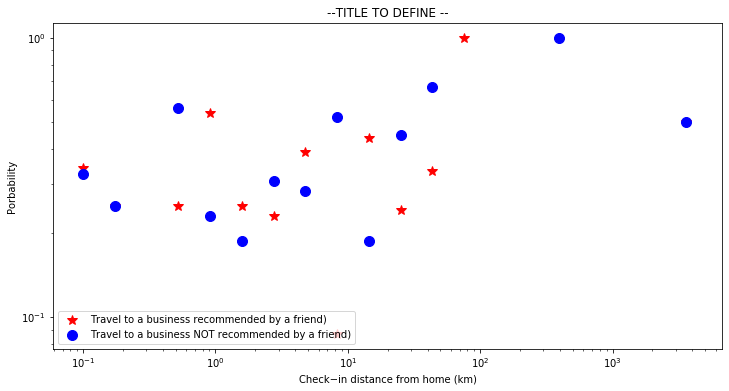

In [103]:
plt.figure(figsize=(12, 6))
# What I obtain previously, with the first P_null
#plt.subplot(121)
plt.plot(np.append(interval_dist,interval_dist[-1:]*1.1),good_reviews,'r*', markersize=10,label='Travel to a business recommended by a friend)')
plt.plot(np.append(interval_dist,interval_dist[-1:]*1.1),bad_reviews,'bo', markersize=10,label='Travel to a business NOT recommended by a friend)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Porbability")
plt.xlabel("Check−in distance from home (km)")
plt.legend(loc="lower left")
plt.title("--TITLE TO DEFINE --")

plt.show()

### Study friend's ratings influence on mobility with respect to traveling distance
##### 1. Friend recommend 
- the x-axis: the distance travelled 
- the y-axis: the probability to travel to distance d and traveling to a business recommended by a friend (i.e >= 3.5 stars)
Attention: check that friend posted review prior to travelling date 

Sur la dataframe checkins à faire:
- place reviewed label: reviewed by friend before (good review >= 3.5: 2, bad review < 3.5: 1, not reviewed: 0) <-- 1
- place distance label: place label = distance to user's home <-- 2

- group by distance, and for each group card(label 2)/card(group) <-- 2

##### 2. Friend avoid 
- the x-axis: the distance travelled 
- the y-axis: the probability to travel to distance d and traveling to a business not recommended by a friend (i.e < 3.5 stars)


### Words of mouth effect: 
Only on checkins that have been a reviewed by a friend before, study the probability to move to a well reviewed business with respect to distance 
- the x-axis: the distance travelled 
- the y-axis: the probability to travel to distance x and traveling to businesses (reviewed by a friend) and (with a rate greater or equal than 3.5)

- group by distance, and for each group card(label 2)/[card(label 2) + card(label 1)] <-- 2